In [98]:
import os
import pandas as pd
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from matplotlib import rc 

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.Data load

In [99]:
# 본 개발자는 코랩을 사용하여 이번 셀은 이를 사용하였지만 외부에서 돌리면 에러가 날 수 있습니다. 
input_file = '/content/drive/My Drive/datacam/bike/'

allFile_list = sorted(glob.glob(os.path.join(input_file, 'return_data_2020_*.csv')))
print(allFile_list)

allData = []

for file in allFile_list:
  df = pd.read_csv(file, encoding='cp949')
  allData.append(df)

['/content/drive/My Drive/datacam/bike/return_data_2020_01.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_02.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_03.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_04.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_05.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_06.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_07.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_08.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_09.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_10.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_11.csv', '/content/drive/My Drive/datacam/bike/return_data_2020_12.csv']


In [100]:
# 본 개발자는 코랩을 사용하여 이번 셀은 이를 사용하였지만 외부에서 돌리면 에러가 날 수 있습니다. 
bike = pd.DataFrame()
dataCombine = pd.concat(allData, axis=0)
bike = dataCombine
bike

,보관소명,년,월,일,요일,시간,반납량,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_승차인원,구
0,(구)신한은행 중랑교지점,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727.0,384600.6820,0.0,중랑구
1,(구)신한은행 중랑교지점,2020,1,1,수,1,1,-5.2,0.0,31.0,16.0,74678.0,386599.3398,0.0,중랑구
2,(구)신한은행 중랑교지점,2020,1,1,수,2,2,-5.1,0.0,31.0,16.0,73718.0,388041.4154,0.0,중랑구
3,(구)신한은행 중랑교지점,2020,1,1,수,3,2,-5.3,0.0,31.0,16.0,73376.0,388881.0968,0.0,중랑구
4,(구)신한은행 중랑교지점,2020,1,1,수,4,0,-4.8,0.0,31.0,16.0,73378.0,388602.5135,0.0,중랑구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491691,힐스테이트에코,2020,12,31,목,19,1,-6.2,0.0,27.0,10.0,156311.0,534962.2667,0.0,강서구
1491692,힐스테이트에코,2020,12,31,목,20,2,-6.5,0.0,27.0,10.0,152987.0,539474.7866,0.0,강서구
1491693,힐스테이트에코,2020,12,31,목,21,1,-6.2,0.0,27.0,10.0,147288.0,542663.5689,0.0,강서구
1491694,힐스테이트에코,2020,12,31,목,22,0,-6.4,0.0,27.0,10.0,144520.0,544189.3726,0.0,강서구


In [3]:
# 여기서부터 실행하십시오
import pandas as pd
bike = pd.DataFrame()
for mon in range(1,13):
    if mon < 10:
        return_ = pd.read_csv('return_last_2020'+'0'+ str(mon) + '.csv', encoding='cp949')
        bike = pd.concat([bike,return_])
    elif mon >= 10:
        return_ = pd.read_csv('return_last_2020'+ str(mon) + '.csv', encoding='cp949')
        bike = pd.concat([bike,return_])
        
bike


,보관소명,구,년,월,일,요일,시간,반납량,기온,강수,미세먼지,초미세먼지,총유입인구,총생활인구,지하철_승차인원
0,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,0,0,-2.2,0.1,31.0,16.0,76727,384600,0.0
1,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,1,1,-5.2,0.0,31.0,16.0,74678,386599,0.0
2,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,2,2,-5.1,0.0,31.0,16.0,73718,388041,0.0
3,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,3,2,-5.3,0.0,31.0,16.0,73376,388881,0.0
4,(구)신한은행 중랑교지점,중랑구,2020,1,1,수,4,0,-4.8,0.0,31.0,16.0,73378,388602,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522778,힐스테이트에코,강서구,2020,12,31,목,19,1,-6.2,0.0,27.0,10.0,156311,534962,0.0
1522779,힐스테이트에코,강서구,2020,12,31,목,20,2,-6.5,0.0,27.0,10.0,152987,539474,0.0
1522780,힐스테이트에코,강서구,2020,12,31,목,21,1,-6.2,0.0,27.0,10.0,147288,542663,0.0
1522781,힐스테이트에코,강서구,2020,12,31,목,22,0,-6.4,0.0,27.0,10.0,144520,544189,0.0


## 2.Preprocessing

In [101]:
def convert_df(df):
  df['time'] = time_date(df)
  df = df.reindex(columns=['보관소명', '년', '월', '일', '요일', '시간', '기온', '강수', 
                          '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', '총생활인구수', '지하철_승차인원', '반납량', 'time'])
  df = df.join(pd.get_dummies(df['요일'], prefix="요일"))
  return_df = df[['time', '반납량']]
  convert_df = df.drop(['보관소명', '년','time', '요일'], axis=1)
  return convert_df, rent_df

In [102]:
def time_date(df):
  
  time = []
  length = len(df['보관소명'])

  for i in range(length):
    yyyy = df['년'][i]
    mm = df['월'][i]
    dd = df['일'][i]
    tt = df['시간'][i]
    time.append((datetime.datetime(yyyy,mm,dd,tt)).strftime('%Y-%m-%d %H:%M:%S'))

  return time

In [103]:
dduk = bike[bike['보관소명'] == '뚝섬유원지역 1번출구 앞']
dduk.reset_index(inplace=True,drop=True)
dduk, return_df = convert_df(dduk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
df = dduk

In [105]:
df

,월,일,시간,기온,강수,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),총유입인구,총생활인구수,지하철_승차인원,반납량,요일_금,요일_목,요일_수,요일_월,요일_일,요일_토,요일_화
0,1,1,0,-2.2,0.1,28.0,16.0,88512.0,390059.2798,0.0,1,0,0,1,0,0,0,0
1,1,1,1,-4.9,0.0,28.0,16.0,82748.0,387849.1003,0.0,2,0,0,1,0,0,0,0
2,1,1,2,-4.5,0.0,28.0,16.0,80092.0,386270.2843,0.0,0,0,0,1,0,0,0,0
3,1,1,3,-4.7,0.0,28.0,16.0,78082.0,384653.2611,0.0,0,0,0,1,0,0,0,0
4,1,1,4,-4.8,0.0,28.0,16.0,77158.0,383800.3134,0.0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,12,31,19,-5.5,0.0,24.0,12.0,117948.0,365892.7122,168.0,4,0,1,0,0,0,0,0
8780,12,31,20,-5.5,0.0,24.0,12.0,110777.0,363384.4163,158.0,2,0,1,0,0,0,0,0
8781,12,31,21,-5.6,0.0,24.0,12.0,104827.0,363474.4854,107.0,3,0,1,0,0,0,0,0
8782,12,31,22,-5.7,0.0,24.0,12.0,100165.0,362123.0517,63.0,2,0,1,0,0,0,0,0


## 3.Dataset split

In [106]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

7027 1757


## 4.Scaler

In [107]:
f_columns = ['월', '일', '시간','기온', '강수', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '총유입인구', 
              '총생활인구수', '지하철_승차인원', '요일_금', '요일_목',	'요일_수', '요일_월',	'요일_일', '요일_토', '요일_화']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['반납량']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['반납량'] = cnt_transformer.transform(train[['반납량']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['반납량'] = cnt_transformer.transform(test[['반납량']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [108]:
def create_dataset(x, y, time_steps=1):
  xs, ys = [], []
  for i in range(len(x) - time_steps):
    v = x.iloc[i:(i+time_steps)].values
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs), np.array(ys)

In [109]:
window_size = 24

#(samples, window_size, features)
x_train, y_train = create_dataset(train, train['반납량'], window_size)
x_test, y_test = create_dataset(test, test['반납량'], window_size)

print(x_train.shape, y_train.shape)

(7003, 24, 18) (7003,)


In [110]:
train_data

(<PrefetchDataset shapes: ((None, None, 24, 15), (None, 24, 15)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>)

In [111]:
x_train.shape[1]

24

In [112]:
y_test

array([ 1.53333333,  1.73333333,  2.13333333, ..., -0.13333333,
       -0.2       , -0.13333333])

In [113]:
x_train.shape[2]

18

In [114]:
x_train

array([[[-0.8       , -0.93333333, -0.91666667, ...,  0.        ,
          0.        ,  0.        ],
        [-0.8       , -0.93333333, -0.83333333, ...,  0.        ,
          0.        ,  0.        ],
        [-0.8       , -0.93333333, -0.75      , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.8       , -0.93333333,  0.83333333, ...,  0.        ,
          0.        ,  0.        ],
        [-0.8       , -0.93333333,  0.91666667, ...,  0.        ,
          0.        ,  0.        ],
        [-0.8       , -0.93333333,  1.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.8       , -0.93333333, -0.83333333, ...,  0.        ,
          0.        ,  0.        ],
        [-0.8       , -0.93333333, -0.75      , ...,  0.        ,
          0.        ,  0.        ],
        [-0.8       , -0.93333333, -0.66666667, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.8       , -0.93333333,  0.91666667, ...,  

## 5.Modeling & Training

In [115]:
model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='sigmoid'),
        Dense(1),
])

In [116]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [119]:
data_path = '/content/drive/My Drive/datacam'

earlystopping = EarlyStopping(monitor='val_loss', patience=20)
filename = os.path.join(data_path, 'return_checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weight_only = True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    shuffle=True,
                    epochs=200,
                    batch_size=32,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
197/197 [==============================] - 7s 36ms/step - loss: 0.4834 - mean_absolute_error: 0.4056 - val_loss: 0.4299 - val_mean_absolute_error: 0.4244

Epoch 00001: val_loss improved from inf to 0.42989, saving model to /content/drive/My Drive/datacam/return_checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


Epoch 2/200
197/197 [==============================] - 7s 34ms/step - loss: 0.4027 - mean_absolute_error: 0.3774 - val_loss: 0.5493 - val_mean_absolute_error: 0.4921

Epoch 00002: val_loss did not improve from 0.42989
Epoch 3/200
197/197 [==============================] - 7s 34ms/step - loss: 0.3421 - mean_absolute_error: 0.3549 - val_loss: 0.3755 - val_mean_absolute_error: 0.4011

Epoch 00003: val_loss improved from 0.42989 to 0.37548, saving model to /content/drive/My Drive/datacam/return_checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


Epoch 4/200
197/197 [==============================] - 7s 34ms/step - loss: 0.3195 - mean_absolute_error: 0.3430 - val_loss: 0.4042 - val_mean_absolute_error: 0.4258

Epoch 00004: val_loss did not improve from 0.37548
Epoch 5/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2985 - mean_absolute_error: 0.3359 - val_loss: 0.3499 - val_mean_absolute_error: 0.3918

Epoch 00005: val_loss improved from 0.37548 to 0.34988, saving model to /content/drive/My Drive/datacam/return_checkpointer.ckpt


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


Epoch 6/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2875 - mean_absolute_error: 0.3256 - val_loss: 0.3756 - val_mean_absolute_error: 0.3962

Epoch 00006: val_loss did not improve from 0.34988
Epoch 7/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2697 - mean_absolute_error: 0.3167 - val_loss: 0.3849 - val_mean_absolute_error: 0.4026

Epoch 00007: val_loss did not improve from 0.34988
Epoch 8/200
197/197 [==============================] - 7s 33ms/step - loss: 0.2584 - mean_absolute_error: 0.3091 - val_loss: 0.3949 - val_mean_absolute_error: 0.4071

Epoch 00008: val_loss did not improve from 0.34988
Epoch 9/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2624 - mean_absolute_error: 0.3086 - val_loss: 0.3773 - val_mean_absolute_error: 0.3883

Epoch 00009: val_loss did not improve from 0.34988
Epoch 10/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2468 - mean_absolute_error: 0.3015 - val_loss: 0.

INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/datacam/return_checkpointer.ckpt/assets


Epoch 11/200
197/197 [==============================] - 7s 33ms/step - loss: 0.2428 - mean_absolute_error: 0.3021 - val_loss: 0.4590 - val_mean_absolute_error: 0.4470

Epoch 00011: val_loss did not improve from 0.32621
Epoch 12/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2365 - mean_absolute_error: 0.2964 - val_loss: 0.3469 - val_mean_absolute_error: 0.3867

Epoch 00012: val_loss did not improve from 0.32621
Epoch 13/200
197/197 [==============================] - 7s 33ms/step - loss: 0.2295 - mean_absolute_error: 0.2924 - val_loss: 0.3807 - val_mean_absolute_error: 0.4003

Epoch 00013: val_loss did not improve from 0.32621
Epoch 14/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2580 - mean_absolute_error: 0.2988 - val_loss: 0.3301 - val_mean_absolute_error: 0.3556

Epoch 00014: val_loss did not improve from 0.32621
Epoch 15/200
197/197 [==============================] - 6s 33ms/step - loss: 0.2330 - mean_absolute_error: 0.2926 - val_loss

## 6.Visualization

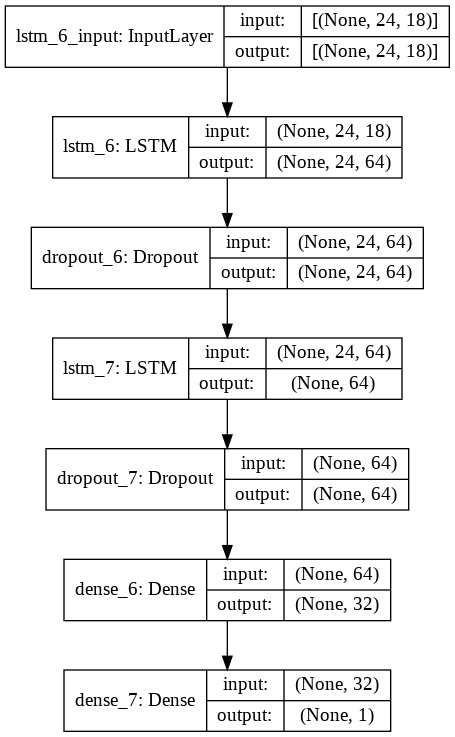

In [120]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

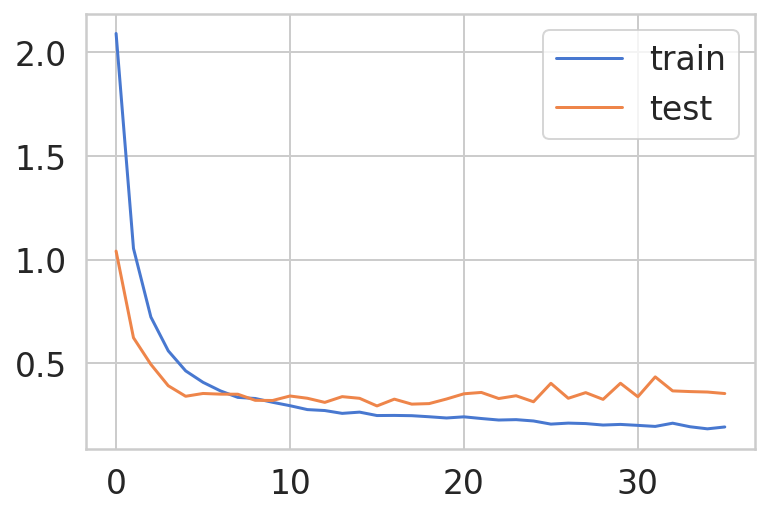

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [46]:
model.load_weights(filename)
y_pred = model.predict(x_test)

In [47]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
#pred_inv = cnt_transformer.inverse_transform(pred)

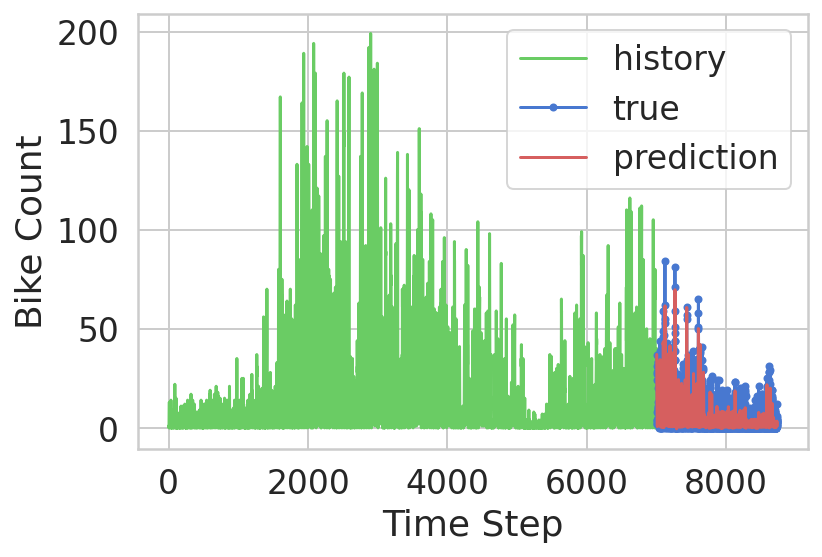

In [48]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

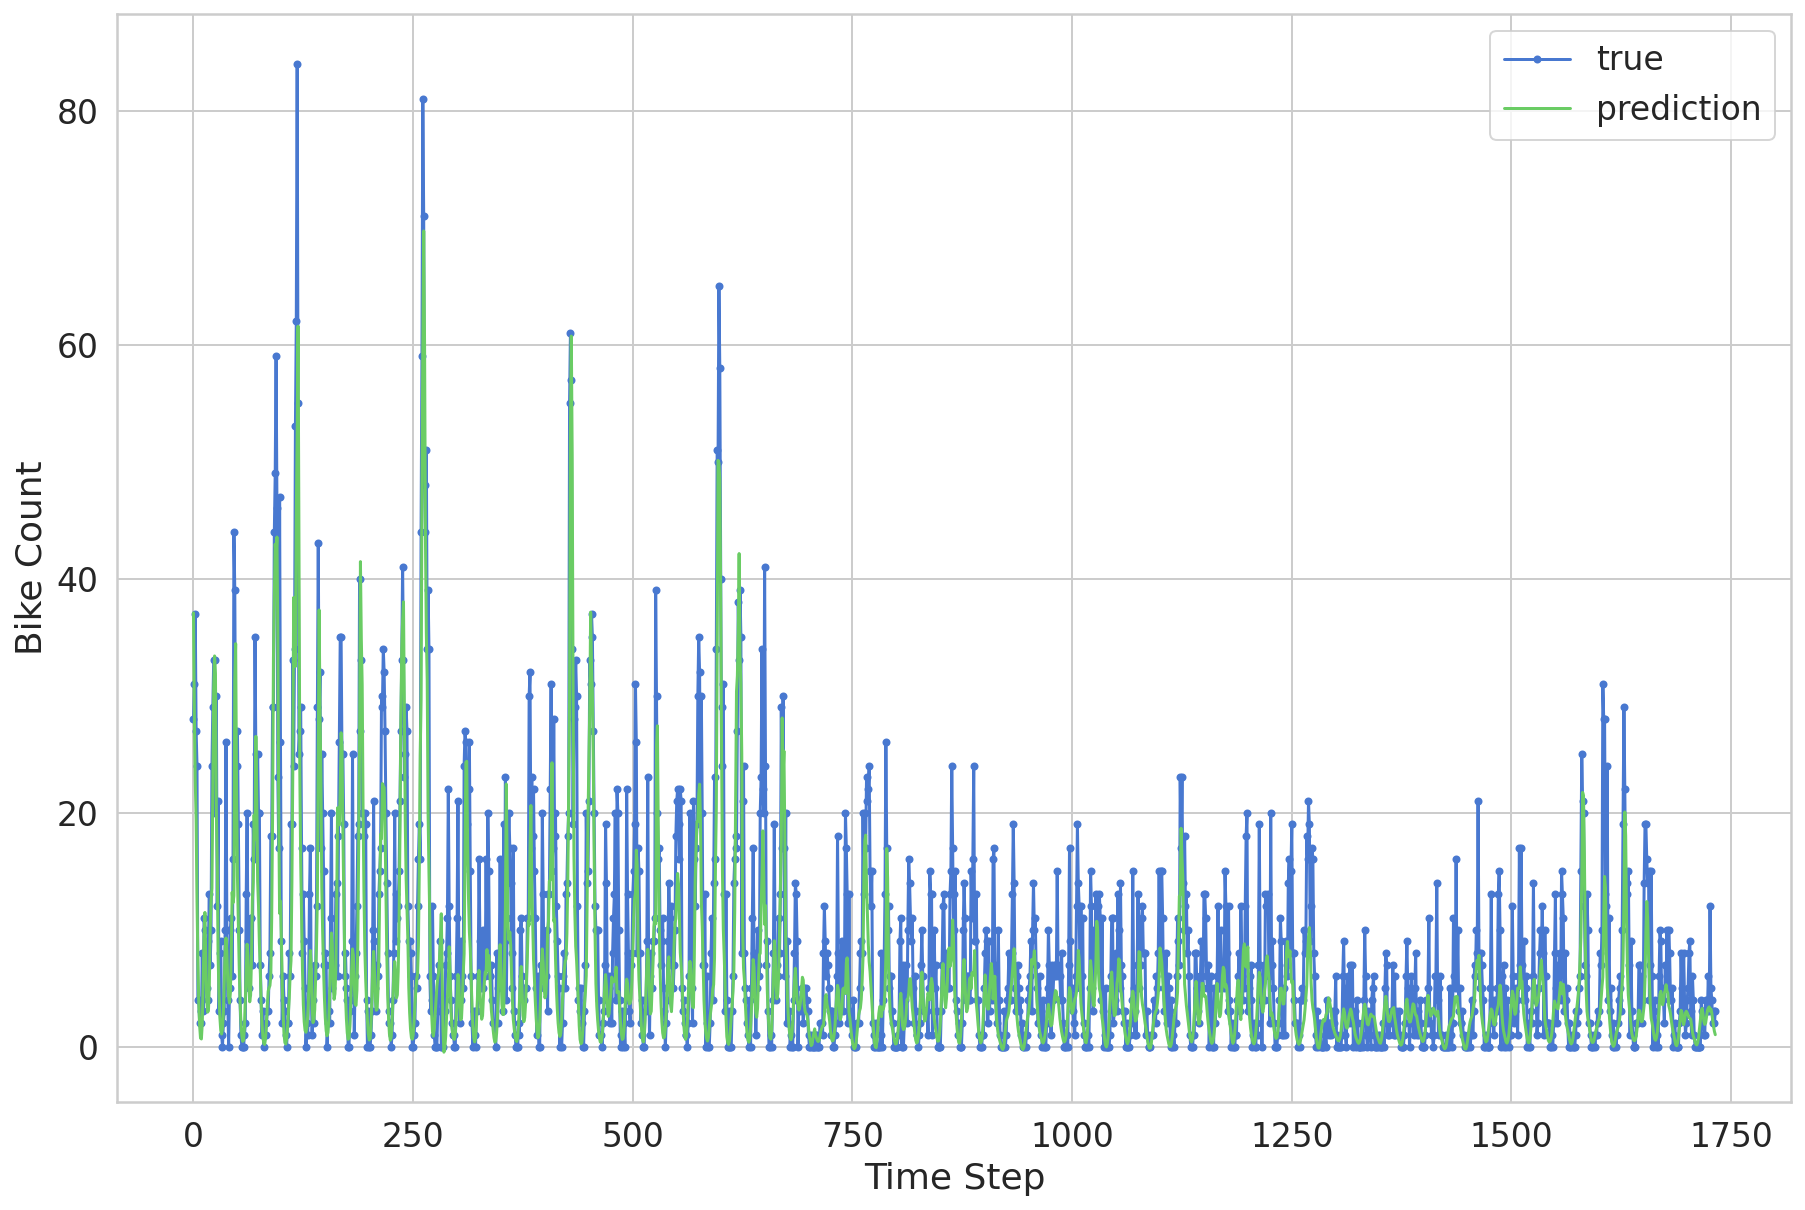

In [49]:
plt.figure(figsize=(15,10))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'g', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

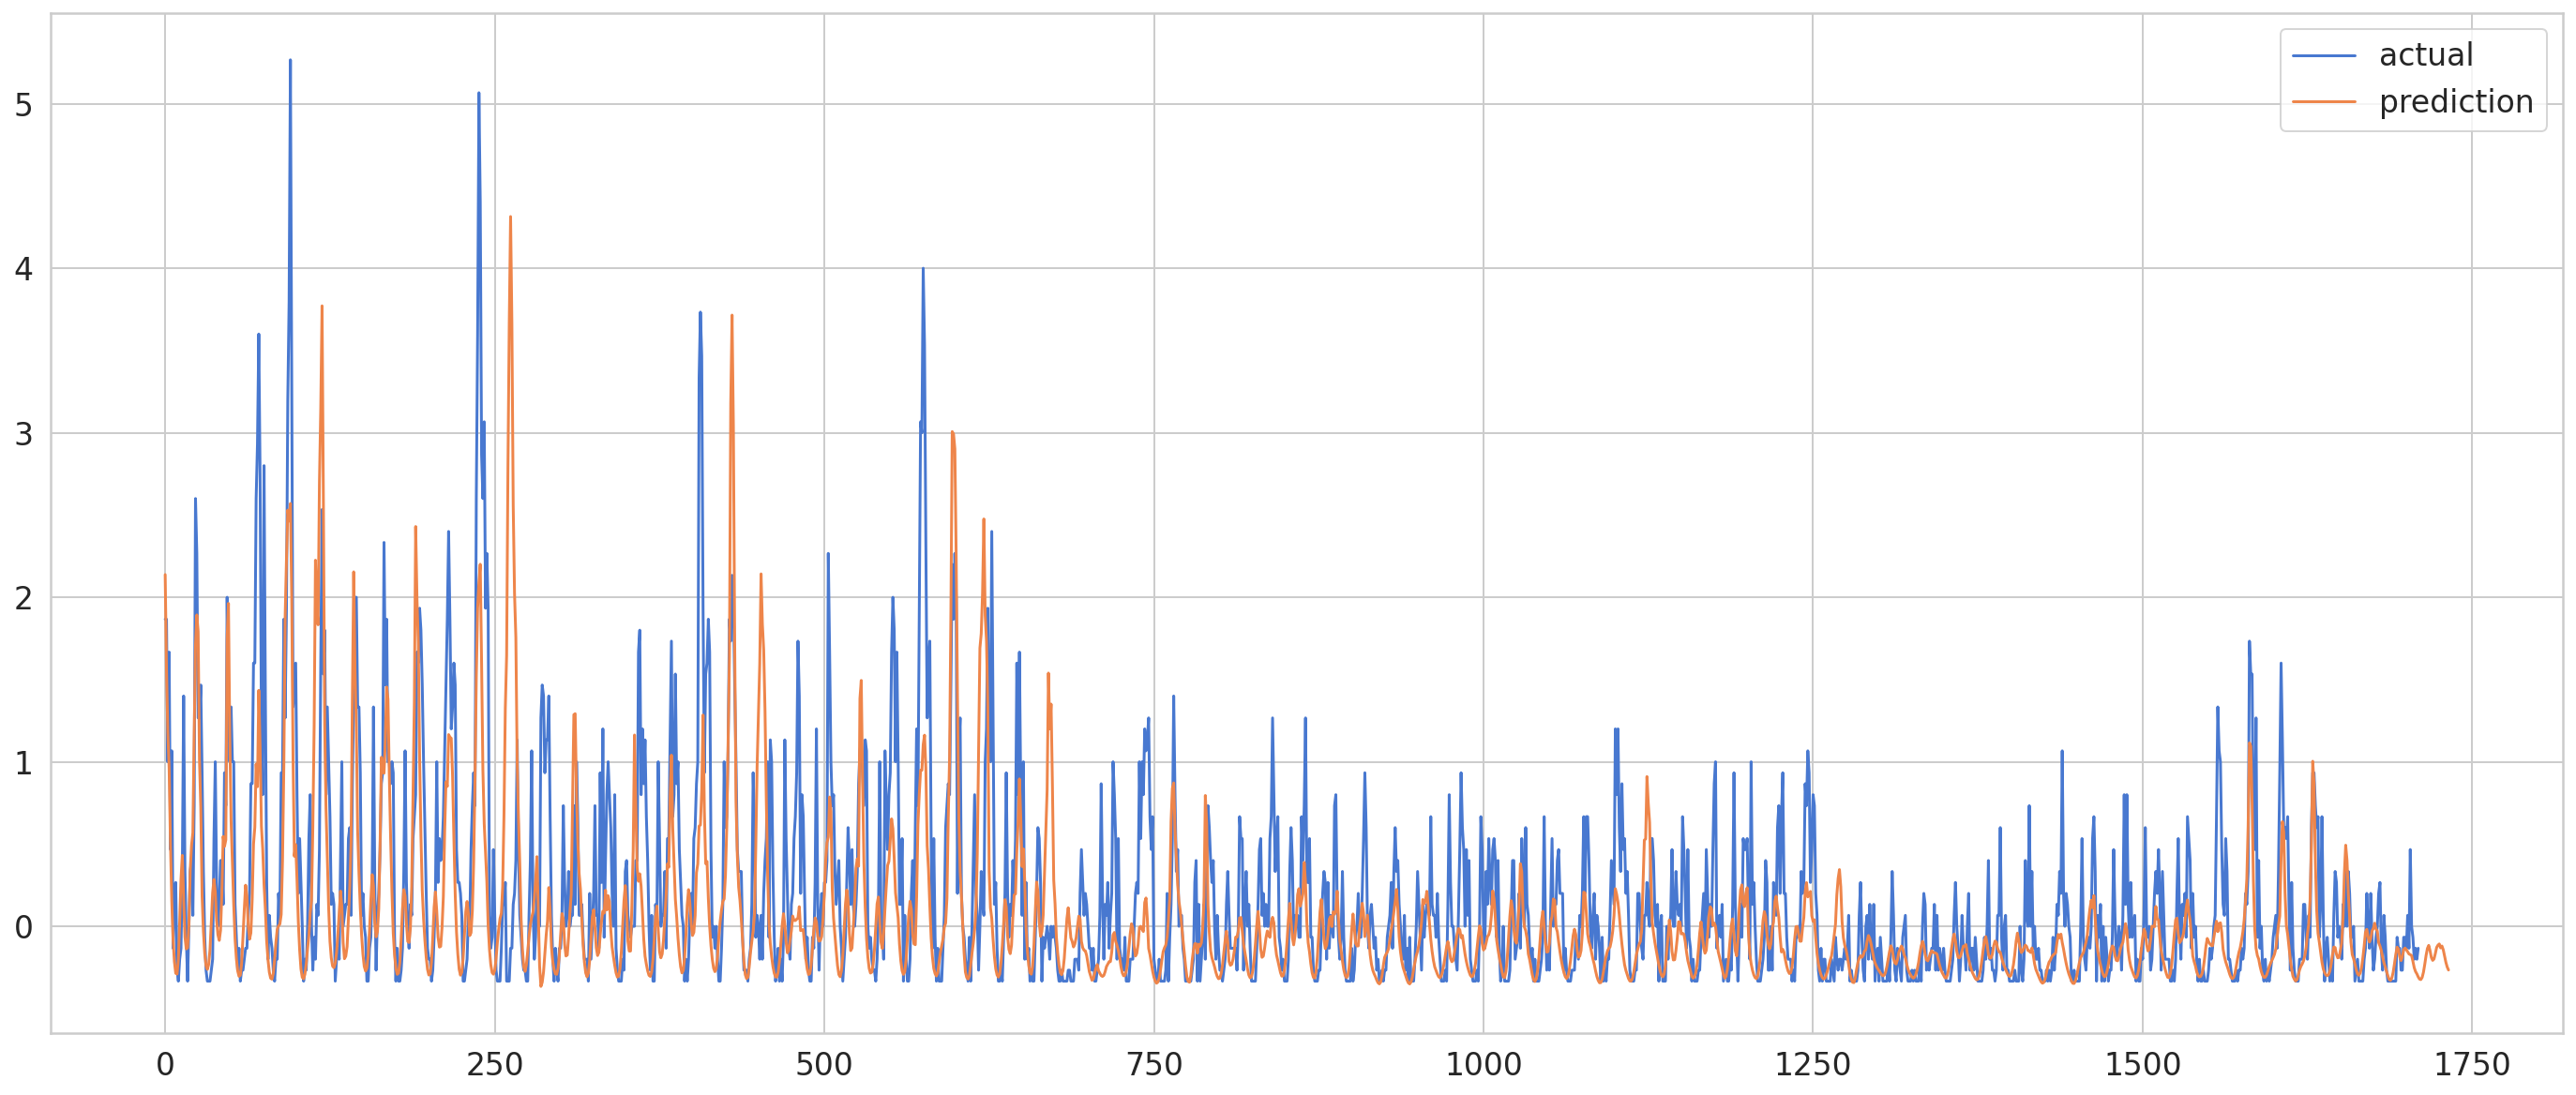

In [50]:
plt.figure(figsize=(24, 10))
plt.plot(np.asarray(y_test)[23:], label='actual')
plt.plot(y_pred[:], label='prediction')
plt.legend()
plt.show()

In [51]:
result = pd.DataFrame(y_pred_inv, columns=['예측값'])
result

,예측값
0,37.067688
1,28.303162
2,22.714024
3,19.399153
4,12.538256
...,...
1728,2.868629
1729,2.290520
1730,1.721055
1731,1.290372


In [52]:
c= []
c = result['예측값']

In [53]:
c = np.around(c)

In [54]:
real = rent_df.iloc[7051:]
real.reset_index(inplace=True, drop=True)
real

,time,반납량
0,2020-10-20 19:00:00,28
1,2020-10-20 20:00:00,31
2,2020-10-20 21:00:00,37
3,2020-10-20 22:00:00,27
4,2020-10-20 23:00:00,24
...,...,...
1728,2020-12-31 19:00:00,4
1729,2020-12-31 20:00:00,2
1730,2020-12-31 21:00:00,3
1731,2020-12-31 22:00:00,2


In [55]:
real.insert(2, '예측값', c)
real

,time,반납량,예측값
0,2020-10-20 19:00:00,28,37.0
1,2020-10-20 20:00:00,31,28.0
2,2020-10-20 21:00:00,37,23.0
3,2020-10-20 22:00:00,27,19.0
4,2020-10-20 23:00:00,24,13.0
...,...,...,...
1728,2020-12-31 19:00:00,4,3.0
1729,2020-12-31 20:00:00,2,2.0
1730,2020-12-31 21:00:00,3,2.0
1731,2020-12-31 22:00:00,2,1.0
